# Artificial Neural Networks and Deep Learning - Assignment 2



## 📃 Task



In this assignment, you will receive 64x128 grayscale real images from Mars terrain. Pixels in these images are categorized into five classes, each representing a particular type of terrain. This is a semantic segmentation problem, so your goal is to assign the correct class label to each mask pixel.

In [ ]:
is_kaggle = True
is_colab = False
manual_analysis = False  # DO NOT CHANGE TO THIS IF YOU DO NOT WANT TO FILL YOUR DRIVE WITH IMAGES

In [ ]:
# Name of the model using the date
from datetime import datetime

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}"
print(model_filename)

model_241211_124029


## 🌐 Connect Colab to Google Drive

In [ ]:
if is_colab:
    from google.colab import drive

    drive.mount("/gdrive")
    %cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Color map to fix the class representation on the graph
colors = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(np.arange(6), cmap.N)

class_names = ["Background", "Soil", "Bedrock", "Sand", "Big Rock"]

## ⏳ Load the Data

In [ ]:
if is_colab:
    data = np.load("mars_for_students.npz")
elif is_kaggle:
    data = np.load("/kaggle/input/mars-rocks/mars_for_students.npz")  # change this with the actual kaggle path
else:
    data = np.load("../mars_for_students.npz")

training_set = data["training_set"] # ['training_set', 'test_set']
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


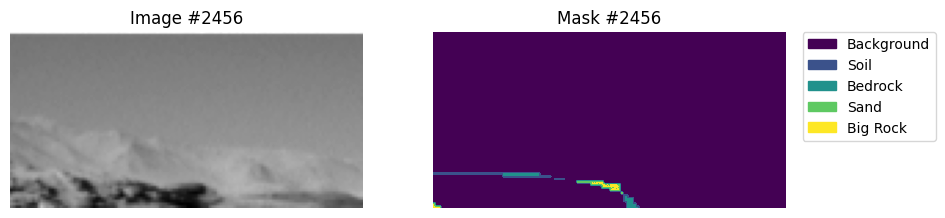

In [ ]:
import random
import matplotlib.patches as mpatches

index = random.randint(0, X_train.shape[0])

# Visualize images and masks
def visualize_sample(image, mask, index):
    plt.figure(figsize=(10, 5))

    # image
    plt.subplot(1, 2, 1)
    plt.title(f"Image #{index}")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # mask
    plt.subplot(1, 2, 2)
    plt.title(f"Mask #{index}")
    plt.imshow(mask, cmap=cmap, norm=norm)
    plt.axis('off')

    # Create custom legend
    colors = cmap.colors
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(5)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

# Visualize an example from the dataset
visualize_sample(X_train[index], y_train[index], index=index)

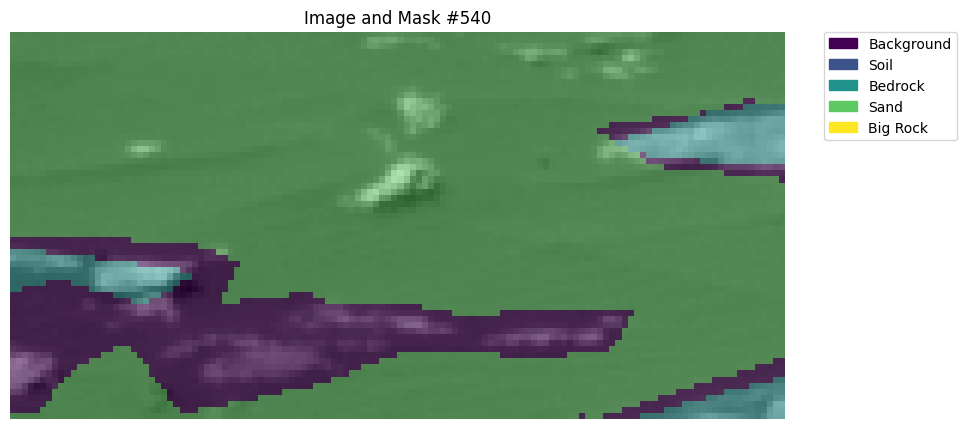

In [ ]:
def display_image_and_mask(image, mask, index):
    plt.figure(figsize=(10, 10))

    # Display image
    plt.subplot(1, 1, 1)
    plt.title(f"Image and Mask #{index}")
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap=cmap, norm=norm, alpha=0.5)  # Add mask with transparency
    plt.axis('off')

    # Create custom legend
    colors = cmap.colors
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(5)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

# Display an example from the dataset
index = 540
display_image_and_mask(X_train[index], y_train[index], index=index)

### 🧹 Data cleaning

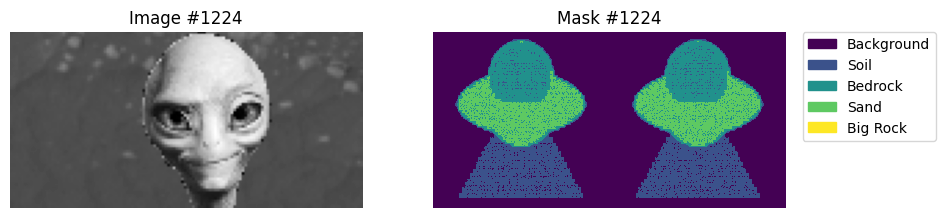

In [ ]:
# Visualize an example from the dataset
index = 1224
visualize_sample(X_train[index], y_train[index], index=index)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

"""
Remove samples from the dataset where the mask matches the alien_mask.

Args:
    X (numpy array): Array of images (shape: [n_samples, height, width]).
    Y (numpy array): Array of masks (shape: [n_samples, height, width]).
    alien_mask (numpy array): The mask to identify alien samples.

Returns:
    X_cleaned, Y_cleaned: Cleaned arrays without alien samples.
"""

def remove_alien_samples(X, Y, alien_mask):
    # Find indices where masks do NOT match the alien mask
    indices_to_keep = [i for i in range(Y.shape[0]) if not np.array_equal(Y[i], alien_mask)]

    # Filter the dataset to keep only valid samples
    X_cleaned = X[indices_to_keep]
    Y_cleaned = Y[indices_to_keep]

    return X_cleaned, Y_cleaned

# Load the alien mask image (the first one is the number 62 of the dataset)
alien_mask = y_train[62]

# remove alien samples from the dataset
X_train_cleaned, y_train_cleaned = remove_alien_samples(X_train, y_train, alien_mask)

# print the shapes of the original and cleaned datasets
print(f"Original shape: {X_train.shape}, {y_train.shape}")
print(f"Cleaned shape: {X_train_cleaned.shape}, {y_train_cleaned.shape}")

# Update the training set with the cleaned data
X_train = X_train_cleaned
y_train = y_train_cleaned

Original shape: (2615, 64, 128), (2615, 64, 128)
Cleaned shape: (2505, 64, 128), (2505, 64, 128)


### 🔍 Inspect the Dataset

In [ ]:
# save valuable information about the dataset
dataset_info = {
    "training_set_shape": X_train.shape,
    "test_set_shape": X_test.shape,
    "image_dimensions": X_train.shape[1:],
    "mask_dimensions": y_train.shape[1:],
    "number_of_classes": len(np.unique(y_train)),
    "segmentation_classes": np.unique(y_train),
}

In [ ]:
# Display information about the dataset
print(f"Dataset keys: {data.files}")
print(f"Training set: {dataset_info['training_set_shape']}")
print(f"Test set: {dataset_info['test_set_shape']}")
print(f"Image dimensions (train): {dataset_info['image_dimensions']}")
print(f"Mask dimensions (train): {dataset_info['mask_dimensions']}")
print(f"Number of classes: {dataset_info['number_of_classes']}")
print(f"Segmentation classes: {dataset_info['segmentation_classes']}")

Dataset keys: ['training_set', 'test_set']
Training set: (2505, 64, 128)
Test set: (10022, 64, 128)
Image dimensions (train): (64, 128)
Mask dimensions (train): (64, 128)
Number of classes: 5
Segmentation classes: [0. 1. 2. 3. 4.]


Class distribution:
Class 0 (Background): 4988826 pixel (24.31%)
Class 1 (Soil): 6957538 pixel (33.90%)
Class 2 (Bedrock): 4776810 pixel (23.28%)
Class 3 (Sand): 3770823 pixel (18.38%)
Class 4 (Big Rock): 26963 pixel (0.13%)


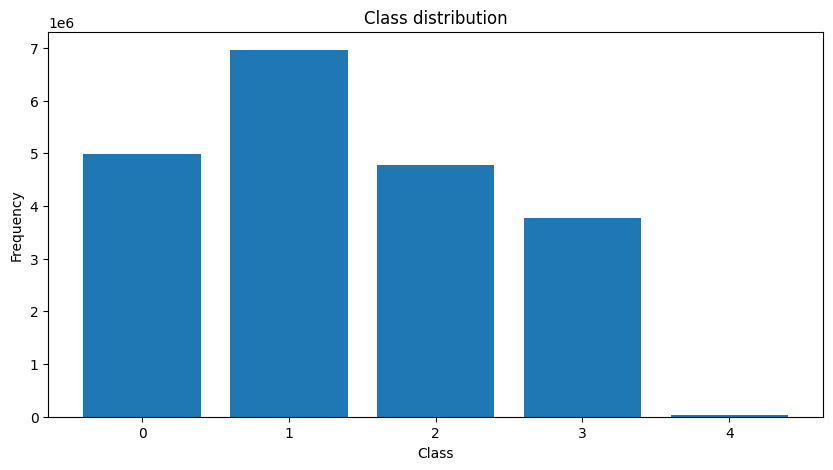

In [ ]:
# Visualize the distribution of classes in the dataset
def display_class_distribution(y_train=y_train):
    unique, counts = np.unique(y_train, return_counts=True)
    class_distribution = dict(zip(unique, counts))

    print("Class distribution:")

    for class_label, count in class_distribution.items():
        print(f"Class {int(class_label)} ({class_names[int(class_label)]}): {count} pixel ({count / np.sum(counts) * 100:.2f}%)")

    # Visualize the class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Class distribution")
    plt.show()

display_class_distribution()

## 🧹 Data Preprocessing

### 📂 Data Splitting

In [ ]:
# # Split the training set into training and validation sets (80% training, 20% validation)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# Display the shapes of the training and validation sets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Training set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### 📊 Data Normalization

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# print shape
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (2004, 64, 128, 1)
Validation set: (501, 64, 128, 1)
Test set: (10022, 64, 128, 1)


### 📚 Data Augmentation

In [ ]:
!pip install -q keras_cv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
print("Image shape:", X_train.shape[1:])
print("Mask shape:", y_train.shape[1:])

Image shape: (64, 128, 1)
Mask shape: (64, 128)


In [ ]:
import keras_cv

# Augmentation pipeline for images and masks
# This augmentation will include transformations that do not change the class of the pixel on the mask
def create_segmentation_augmentation_pipeline(segmentation_classes=dataset_info['number_of_classes'], seed=seed):
    # Define augmentation layers for segmentation

    layers = [
        # Geometric transformations
        keras_cv.layers.RandomFlip(mode='horizontal_and_vertical', seed=seed),
        keras_cv.layers.RandomTranslation(
            height_factor=(-0.5, 0.5),  # Limited shift
            width_factor=(-0.5, 0.5),
            seed=seed,
            fill_mode='reflect'
        ),

        keras_cv.layers.RandomRotation(
            factor=(-0.1, 0.1),  # Slight rotations
            seed=seed,
            fill_mode='reflect',
            segmentation_classes=segmentation_classes
        ),

        keras_cv.layers.RandomCrop(
            height = dataset_info['image_dimensions'][0],
            width = dataset_info['image_dimensions'][1],
            seed=seed,
        ),

        keras_cv.layers.RandomZoom(
            height_factor=(-0.5, 0.5),  # Limited zoom
            width_factor=(-0.5, 0.5),
            seed=seed,
            fill_mode='reflect',
        )
    ]

    # Create the pipeline with moderate application rate
    pipeline = keras_cv.layers.RandomAugmentationPipeline(
        layers=layers,
        augmentations_per_image=2,  # Apply 2 random augmentations per image
        rate=1,  # 100% chance of applying augmentation to each image
        seed=seed
    )

    return pipeline

image_mask_augmentation_pipeline = create_segmentation_augmentation_pipeline(seed = seed)

In [ ]:
def augment_segmentation_data(images, masks, pipeline, segmentation_classes, epoch):
    if epoch % 2 == 0:
        # Concatenate image and mask
        images = tf.cast(images, tf.float32)    # Ensure images are float32
        mask = tf.cast(masks, tf.float32)       # Ensure mask is float32
        combined = tf.concat([images, tf.expand_dims(mask, axis=-1)], axis=-1)

        # Apply augmentation
        augmented = pipeline(combined)

        # Separate augmented images and masks
        augmented_images = augmented[..., :images.shape[-1]]
        augmented_masks = tf.cast(tf.squeeze(augmented[..., images.shape[-1]:], axis=-1), tf.int32) # Ensure mask is int32 again

        return augmented_images, augmented_masks
    else:
        return images, masks

In [ ]:
def visualize_segmentation_augmentations(images, masks, pipeline, epoch, segmentation_classes=dataset_info['number_of_classes'], num_samples=2):
    # Generate random indices
    random_indices = np.random.choice(len(images), size=num_samples, replace=False)

    # Get original images and masks
    original_images = images[random_indices]
    original_masks = masks[random_indices]

    # Prepare figures
    fig, axes = plt.subplots(2, 2*num_samples)
    fig.set_figheight(6)
    fig.set_figwidth(12)

    # Augment samples
    for i, (image, mask) in enumerate(zip(original_images, original_masks)):
        # Apply augmentation
        augmented_image, augmented_mask = augment_segmentation_data(
            tf.expand_dims(image, 0),
            tf.expand_dims(mask, 0),
            pipeline=pipeline,
            segmentation_classes=segmentation_classes,
            epoch = 0
        )

        # Squeeze dimensions
        augmented_image = augmented_image.numpy().squeeze()
        augmented_mask = augmented_mask.numpy().squeeze()

        # Ensure the images and masks have the correct shape
        if len(image.shape) == 2:
            image = image[..., np.newaxis]

        if len(mask.shape) == 2:
            mask = mask[..., np.newaxis]

        if len(augmented_image.shape) == 2:
            augmented_image = augmented_image[..., np.newaxis]

        if len(augmented_mask.shape) == 2:
            augmented_mask = augmented_mask[..., np.newaxis]

        # Plot original image
        axes[0, 2*i].imshow(image[..., 0], cmap='gray')
        axes[0, 2*i].set_title(f'Original Image {random_indices[i]}')
        axes[0, 2*i].axis('off')

        # Plot original mask
        axes[0, 2*i+1].imshow(mask[..., 0], cmap=cmap, norm=norm)
        axes[0, 2*i+1].set_title(f'Original Mask {random_indices[i]}')
        axes[0, 2*i+1].axis('off')

        # Plot augmented image
        axes[1, 2*i].imshow(augmented_image[..., 0], cmap='gray')
        axes[1, 2*i].set_title(f'Augmented Image {random_indices[i]}')
        axes[1, 2*i].axis('off')

        # Plot augmented mask
        axes[1, 2*i+1].imshow(augmented_mask[..., 0], cmap=cmap, norm=norm)
        axes[1, 2*i+1].set_title(f'Augmented Mask {random_indices[i]}')
        axes[1, 2*i+1].axis('off')

        # display image information (shape, min, max, dtype)
        # print(f"Image {random_indices[i]} - Original: {image.shape}, {image.min()}, {image.max()}, {image.dtype}")
        # print(f"Image {random_indices[i]} - Augmented: {augmented_image.shape}, {augmented_image.min()}, {augmented_image.max()}, {augmented_image.dtype}")

    # Create custom legend
    colors = cmap.colors
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(5)]
    fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=5)

    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.tight_layout(h_pad=0.5, w_pad=0.5)
    plt.show()

### ⚖️ Data Balancing

To balance the dataset, we first remove uninformative samples, such as those containing only one class. Then, based on the new distribution, we generate new samples for the underrepresented classes by identifying existing samples and increasing their representation through targeted data augmentation. Finally, we reintegrate the augmented samples into the original dataset, duplicating them to improve class distribution.

In [ ]:
def remove_single_class_samples(X_train, y_train):
  total_removed = 0

  for i in range(dataset_info["number_of_classes"]):
      mask_indeces_with_single_class = [j for j in range(y_train.shape[0]) if np.all(y_train[j] == i)]

      print(f"Class {i} ({class_names[i]}): {len(mask_indeces_with_single_class)} samples")

      total_removed += len(mask_indeces_with_single_class)

      # remove samples with only one class
      if len(mask_indeces_with_single_class) > 0:
          X_train = np.delete(X_train, mask_indeces_with_single_class, axis=0)
          y_train = np.delete(y_train, mask_indeces_with_single_class, axis=0)

  # Display the shapes of the training and validation sets
  print(f"Training set: {X_train.shape}, {y_train.shape}")
  print(f"Removed samples: {total_removed}")

remove_single_class_samples(X_train, y_train)

Class 0 (Background): 4 samples
Class 1 (Soil): 182 samples
Class 2 (Bedrock): 70 samples
Class 3 (Sand): 73 samples
Class 4 (Big Rock): 0 samples
Training set: (1675, 64, 128, 1), (1675, 64, 128)
Removed samples: 329


Class distribution:
Class 0 (Background): 3979893 pixel (24.24%)
Class 1 (Soil): 5532162 pixel (33.70%)
Class 2 (Bedrock): 3924593 pixel (23.91%)
Class 3 (Sand): 2958791 pixel (18.02%)
Class 4 (Big Rock): 21329 pixel (0.13%)


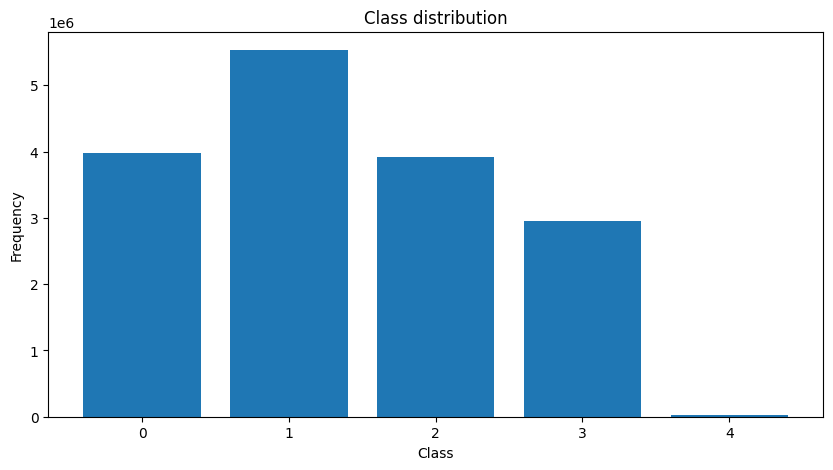

In [ ]:
# Visualize the distribution of classes in the training set
display_class_distribution(y_train)

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

In [ ]:
import numpy as np
import cv2

def balance_classes(X_train, y_train, class_distribution_train):
    """
    Balance dataset by finding and cropping regions of specific classes
    """
    # Find target class distribution (mean of all classes)
    mean_count = np.mean(list(class_distribution_train.values()))
    max_count = max(class_distribution_train.values())

    # Ensure X_train and y_train have consistent shapes
    if X_train.ndim == 3:
        X_train = X_train[..., np.newaxis]
    if y_train.ndim == 3:
        y_train = y_train[..., np.newaxis]

    # Lists to store new samples
    new_X_train = []
    new_y_train = []

    total_added = 0

    for classe, current_count in class_distribution_train.items():
        if classe == 0:  # Skip background
            continue

        # Determine multiplier to balance class
        if classe == 3:
            multiplier = int(mean_count) // (current_count)
        else:
            multiplier = int(mean_count) // (7 * current_count)
        print(f"Multiplier for class {classe}: {int(mean_count)} // {current_count} = {multiplier}")

        # Find images containing the current class
        class_indices = [i for i in range(len(y_train))
                         if classe in np.unique(y_train[i, :, :, 0])]

        class_added = 0

        for idx in class_indices:
            # Find bounding box for the specific class
            mask = y_train[idx, :, :, 0]
            class_mask = (mask == classe).astype(np.uint8)

            # Find contours of the class region
            contours, _ = cv2.findContours(class_mask,
                                           cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_SIMPLE)

            if not contours:
                continue

            # Get bounding rectangle of the class
            x, y, w, h = cv2.boundingRect(contours[0])

            # Extend bounding box with some margin
            margin = max(w, h) // 4
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(X_train[idx].shape[1] - x, w + 2 * margin)
            h = min(X_train[idx].shape[0] - y, h + 2 * margin)

            # Crop image and mask
            cropped_img = X_train[idx][y:y + h, x:x + w, :]
            cropped_mask = y_train[idx][y:y + h, x:x + w, :]

            # Resize to (64, 128)
            resized_img = cv2.resize(cropped_img, (128, 64),
                                     interpolation=cv2.INTER_AREA)
            resized_mask = cv2.resize(cropped_mask, (128, 64),
                                      interpolation=cv2.INTER_NEAREST)

            # Duplicate samples to balance class
            for _ in range(multiplier):
                new_X_train.append(resized_img)
                new_y_train.append(resized_mask)
                class_added += 1

        print(f"Added {class_added} elements for class {classe}")
        total_added += class_added

    print(f"Total elements added: {total_added}")

    # Convert to numpy arrays with consistent shapes
    new_X_train = np.array(new_X_train)
    new_y_train = np.array(new_y_train)

    return new_X_train, new_y_train

# Balance the dataset
X_train_balanced, y_train_balanced = balance_classes(X_train, y_train, class_distribution)


Multiplier for class 1.0: 3283353 // 5532162 = 0
Added 0 elements for class 1.0
Multiplier for class 2.0: 3283353 // 3924593 = 0
Added 0 elements for class 2.0
Multiplier for class 3.0: 3283353 // 2958791 = 1
Added 688 elements for class 3.0
Multiplier for class 4.0: 3283353 // 21329 = 21
Added 1176 elements for class 4.0
Total elements added: 1864


In [ ]:
# Display the shapes of the balanced training set
print(f"Balanced training set: {X_train_balanced.shape}, {y_train_balanced.shape}")

Balanced training set: (1864, 64, 128), (1864, 64, 128)


Class distribution:
Class 0 (Background): 5991158 pixel (39.24%)
Class 1 (Soil): 625108 pixel (4.09%)
Class 2 (Bedrock): 935287 pixel (6.13%)
Class 3 (Sand): 4442558 pixel (29.09%)
Class 4 (Big Rock): 3275777 pixel (21.45%)


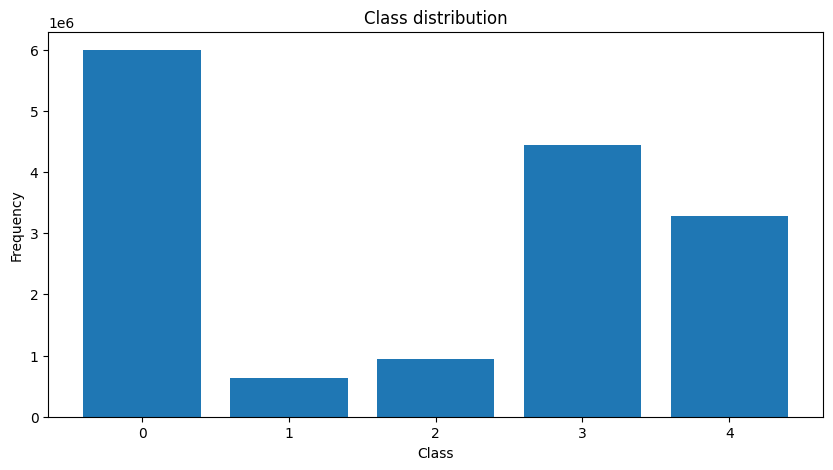

In [ ]:
# Display the distribution of classes in the balanced training set

display_class_distribution(y_train_balanced)

In [ ]:
# Combine the original and balanced datasets
X_train_combined = np.concatenate([X_train, X_train_balanced[..., np.newaxis]], axis=0) # add a new axis to X_train_balanced
y_train_combined = np.concatenate([y_train, y_train_balanced], axis=0)

In [ ]:
remove_single_class_samples(X_train_combined, y_train_combined)

Class 0 (Background): 4 samples
Class 1 (Soil): 182 samples
Class 2 (Bedrock): 70 samples
Class 3 (Sand): 165 samples
Class 4 (Big Rock): 168 samples
Training set: (3279, 64, 128, 1), (3279, 64, 128)
Removed samples: 589


Combined training set: (3868, 64, 128, 1), (3868, 64, 128)
Class distribution:
Class 0 (Background): 9971051 pixel (31.47%)
Class 1 (Soil): 6157270 pixel (19.43%)
Class 2 (Bedrock): 4859880 pixel (15.34%)
Class 3 (Sand): 7401349 pixel (23.36%)
Class 4 (Big Rock): 3297106 pixel (10.41%)


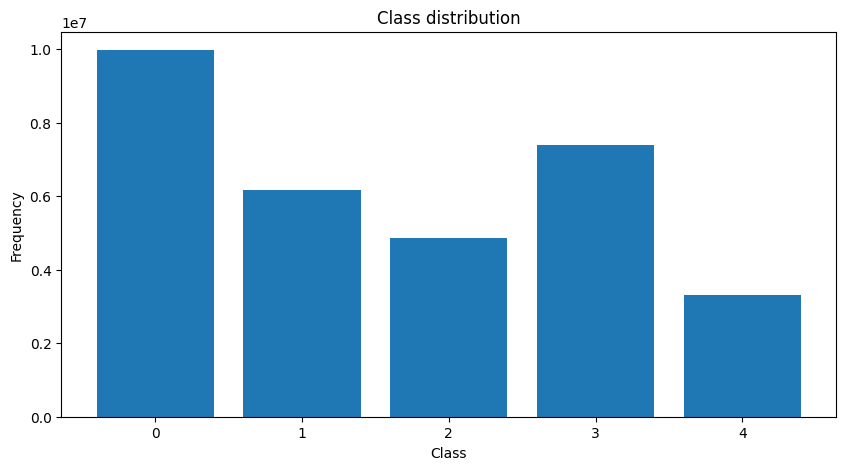

In [ ]:
# Display the shapes of the combined training set
print(f"Combined training set: {X_train_combined.shape}, {y_train_combined.shape}")

# Display the distribution of classes in the combined training set
display_class_distribution(y_train_combined)

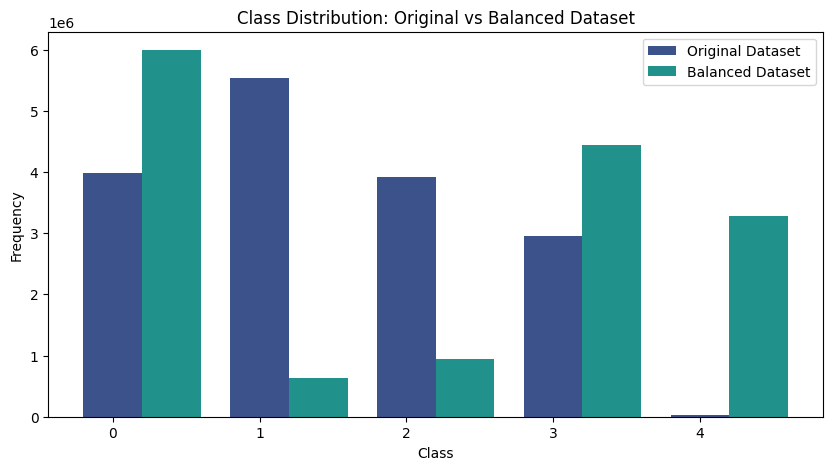

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the class distribution for the original dataset
unique_original, counts_original = np.unique(y_train, return_counts=True)
class_distribution_original = dict(zip(unique_original, counts_original))

# Calculate the class distribution for the balanced dataset
unique_balanced, counts_balanced = np.unique(y_train_balanced, return_counts=True)
class_distribution_balanced = dict(zip(unique_balanced, counts_balanced))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot for the original dataset
ax.bar(class_distribution_original.keys(), class_distribution_original.values(), width=0.4, align='center', label='Original Dataset', color=cmap.colors[1])

# Plot for the balanced dataset
ax.bar(np.array(list(class_distribution_balanced.keys())) + 0.4, class_distribution_balanced.values(), width=0.4, align='center', label='Balanced Dataset', color=cmap.colors[2])

# Add labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.set_title('Class Distribution: Original vs Balanced Dataset')
ax.legend()

# Show the plot
plt.show()

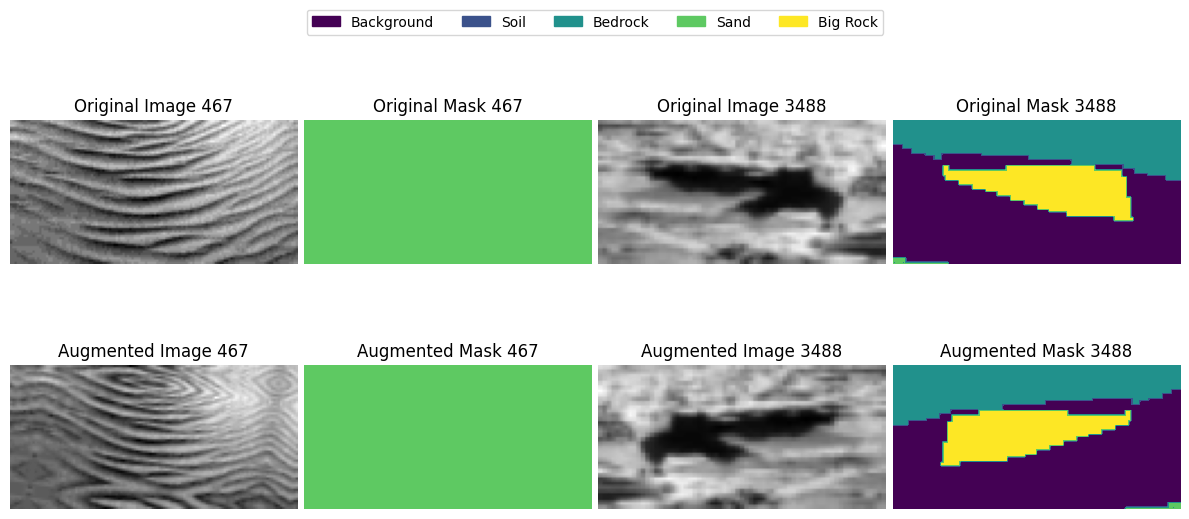

In [ ]:
# Visualize augmentations
visualize_segmentation_augmentations(
    X_train_combined, y_train_combined,
    pipeline=image_mask_augmentation_pipeline,
    segmentation_classes=dataset_info['number_of_classes'],
    epoch=0,
)

## 🧮 Define Network Parameters

In [ ]:
# Number of training epochs
epochs = 500

# Batch size for training
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

### 💽 Dataset Creation

In [ ]:
print(f"Combined training set: {X_train_combined.shape}, {y_train_combined.shape}")
print(f"Training set: {X_train.shape}, {y_train.shape}")

Combined training set: (3868, 64, 128, 1), (3868, 64, 128)
Training set: (2004, 64, 128, 1), (2004, 64, 128)


In [ ]:
# Convert the data types of the original dataset to match those of the augmented dataset
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)
X_train_combined = X_train_combined.astype(np.float32)
y_train_combined = y_train_combined.astype(np.int32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.int32)

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_combined, y_train_combined))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# create an augmentation dataset
train_aug_dataset = tf.data.Dataset.from_tensor_slices((X_train_combined, y_train_combined))
train_aug_dataset = train_aug_dataset.shuffle(buffer_size=1024).batch(batch_size)

# apply augmentation to the dataset using the augmentation pipeline
# all the training samples will be augmented
train_aug_dataset = train_aug_dataset.map(
    lambda x, y: augment_segmentation_data(
        x, y, image_mask_augmentation_pipeline, dataset_info['number_of_classes'], epoch=epochs
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

# merge the augmented dataset with the original one
# train_dataset = train_dataset.concatenate(train_aug_dataset)
train_dataset = train_aug_dataset

# Shuffle the training set
train_dataset = train_dataset.shuffle(buffer_size=1024)

# Prefetch the dataset
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# print training dataset shape
print(f"Training dataset: {train_dataset}")
print(f"Validation dataset: {val_dataset}")

Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 128), dtype=tf.int32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 128), dtype=tf.int32, name=None))>


In [ ]:
def inspect_dataset(dataset):
    print("Dettagli del dataset:")
    for images, masks in dataset.take(1):
        print("Forma batch immagini:", images.shape)
        print("Tipo immagini:", images.dtype)
        print("Forma batch maschere:", masks.shape)
        print("Tipo maschere:", masks.dtype)

        # Controlli aggiuntivi
        print("\nControlli aggiuntivi:")
        # Flatten the masks before applying tf.unique
        unique_values, _ = tf.unique(tf.reshape(masks, [-1]))
        print("Numero di classi nelle maschere:", unique_values.shape)
        print("Valori unici nelle maschere:", unique_values)

# Ispeziona il dataset
inspect_dataset(train_dataset)

Dettagli del dataset:
Forma batch immagini: (64, 64, 128, 1)
Tipo immagini: <dtype: 'float32'>
Forma batch maschere: (64, 64, 128)
Tipo maschere: <dtype: 'int32'>

Controlli aggiuntivi:
Numero di classi nelle maschere: (5,)
Valori unici nelle maschere: tf.Tensor([1 0 2 3 4], shape=(5,), dtype=int32)


## 🏋️‍♂️ Model Definition

In [ ]:
# input shape
input_shape = X_train_combined.shape[1:]
print(f"Input shape: {input_shape}")

# number of classes
num_classes = len(np.unique(y_train_combined))
print(f"Number of classes: {num_classes}")

# Print the shapes of the training and validation sets
print(f"Training set: {X_train_combined.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Input shape: (64, 128, 1)
Number of classes: 5
Training set: (3868, 64, 128, 1), (2004, 64, 128)
Validation set: (501, 64, 128, 1), (501, 64, 128)


In [ ]:
def cellular_automata_module(input_tensor, num_steps=5, filters=64, kernel_size=3, activation='relu', name='ca_module'):
    """
    Cellular Automata module for local feature refinement through iterative updates.

    Args:
        input_tensor: Input tensor to be refined.
        num_steps: Number of CA iterations.
        filters: Number of output filters in the CA operation.
        kernel_size: Size of the convolutional kernel for local interaction.
        activation: Activation function to apply after updates.
        name: Prefix for layer naming.

    Returns:
        Refined tensor after CA iterations.
    """
    x = input_tensor

    for step in range(num_steps):
        # Local interaction through convolution
        neighbors = tfkl.Conv2D(
            filters,
            kernel_size=kernel_size,
            padding='same',
            activation=activation,
            name=f"{name}_conv{step+1}"
        )(x)

        # Combine original features with updated features (residual connection)
        x = tfkl.Add(name=f"{name}_add{step+1}")([x, neighbors])
        x = tfkl.Activation(activation, name=f"{name}_activation{step+1}")(x)

    return x


In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl

def squeeze_and_excitation_block(input_tensor, ratio=16):
    """
    Squeeze-and-Excitation block for channel-wise adaptive feature recalibration

    Args:
        input_tensor: Input feature map
        ratio: Reduction ratio for channel compression

    Returns:
        Feature map with channel-wise attention
    """
    channels = input_tensor.shape[-1]

    # Global average pooling
    squeeze = tfkl.GlobalAveragePooling2D()(input_tensor)

    # Excitation block with bottleneck
    excitation = tfkl.Dense(channels // ratio, activation='relu', use_bias=False)(squeeze)
    excitation = tfkl.Dense(channels, activation='sigmoid', use_bias=False)(excitation)

    # Reshape to apply channel-wise scaling
    excitation = tfkl.Reshape((1, 1, channels))(excitation)

    # Scale input tensor
    return tfkl.Multiply()([input_tensor, excitation])

In [ ]:
def dilated_inception_block(input_tensor, filters):
    """
    Dilated Inception-style block for multi-scale feature extraction

    Args:
        input_tensor: Input feature map
        filters: Number of output filters

    Returns:
        Multi-scale feature representation
    """
    # Parallel dilated convolutions with different rates
    branch1 = tfkl.Conv2D(filters//4, kernel_size=1, padding='same')(input_tensor)

    branch2 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=1)(input_tensor)
    branch3 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=3)(input_tensor)
    branch4 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=5)(input_tensor)

    # Concatenate branches
    x = tfkl.Concatenate()([branch1, branch2, branch3, branch4])

    # Reduce to original filter size
    x = tfkl.Conv2D(filters, kernel_size=1, padding='same')(x)

    return x

In [ ]:
def global_context_module(input_tensor):
    """
    Global Context Module for capturing global spatial dependencies

    Args:
        input_tensor: Input feature map

    Returns:
        Feature map with global context
    """
    # Global context path
    global_context = tfkl.GlobalAveragePooling2D()(input_tensor)
    global_context = tfkl.Dense(input_tensor.shape[-1], activation='relu')(global_context)
    global_context = tfkl.Dense(input_tensor.shape[-1], activation='sigmoid')(global_context)
    global_context = tfkl.Reshape((1, 1, input_tensor.shape[-1]))(global_context)

    # Apply global context
    return tfkl.Multiply()([input_tensor, global_context])

In [ ]:
def cross_branch_attention(macro_features, micro_features):
    """
    Cross-branch attention mechanism to enhance feature interaction

    Args:
        macro_features: Features from macro feature extractor
        micro_features: Features from micro feature extractor

    Returns:
        Mutually enhanced feature representation
    """
    # Ensure consistent channel dimensions
    target_channels = max(macro_features.shape[-1], micro_features.shape[-1])

    # Adjust features to have the same number of channels
    macro_adjusted = tfkl.Conv2D(target_channels, kernel_size=1, padding='same')(macro_features)
    micro_adjusted = tfkl.Conv2D(target_channels, kernel_size=1, padding='same')(micro_features)

    # Create attention maps
    macro_attn = tfkl.Conv2D(1, kernel_size=1, activation='sigmoid')(macro_adjusted)
    micro_attn = tfkl.Conv2D(1, kernel_size=1, activation='sigmoid')(micro_adjusted)

    # Cross-weighted features
    macro_enhanced = tfkl.Multiply()([macro_adjusted, micro_attn])
    micro_enhanced = tfkl.Multiply()([micro_adjusted, macro_attn])

    # Combine enhanced features with residual connection
    combined = tfkl.Add()([macro_enhanced, micro_enhanced])

    # Add a final 1x1 convolution to refine the features
    refined = tfkl.Conv2D(target_channels, kernel_size=1, padding='same')(combined)

    return refined

In [ ]:
def residual_unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    """
    Enhanced UNet block with residual connections and improved feature representation

    Args:
        input_tensor: Input tensor to the block
        filters: Number of convolutional filters
        kernel_size: Size of convolutional kernels
        activation: Activation function
        stack: Number of convolutional layers in the block
        name: Prefix for layer naming

    Returns:
        Processed tensor with residual connections
    """
    # Store the original input for residual connection
    shortcut = input_tensor

    x = input_tensor
    for i in range(stack):
        # Convolutional layers with batch normalization and activation
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same',
                        kernel_initializer='he_normal',
                        name=name + f'conv{i+1}')(x)
        x = tfkl.BatchNormalization(name=name + f'bn{i+1}')(x)
        x = tfkl.Activation(activation, name=name + f'activation{i+1}')(x)

    # Residual connection
    # If input and output tensor have different dimensions, use a 1x1 convolution
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'shortcut_adjust')(shortcut)

    # Add residual connection with optional squeeze-and-excitation
    x = tfkl.Add(name=name + 'residual_add')([x, shortcut])
    x = tfkl.Activation(activation)(x)

    return x

In [ ]:
def create_enhanced_dual_unet_model(input_shape, num_classes, seed=42):
    """
    Enhanced Dual UNet architecture with advanced bottleneck processing

    Args:
        input_shape: Shape of input images
        num_classes: Number of output segmentation classes
        seed: Random seed for reproducibility

    Returns:
        Compiled Keras model with advanced feature extraction
    """
    tf.random.set_seed(seed)

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # First UNet - Macro Feature Extractor (Broader Perspective)
    def macro_unet():
        # Downsampling path
        down_block_1 = residual_unet_block(input_layer, 32, name='macro_down_block1')
        d1 = tfkl.MaxPooling2D()(down_block_1)

        down_block_2 = residual_unet_block(d1, 64, name='macro_down_block2')
        d2 = tfkl.MaxPooling2D()(down_block_2)

        # Bottleneck with CA
        bottleneck = dilated_inception_block(d2, 128)
        bottleneck = squeeze_and_excitation_block(bottleneck)
        bottleneck = cellular_automata_module(bottleneck, num_steps=5, filters=128, name='macro_bottleneck_ca')

        # Upsampling path
        u1 = tfkl.UpSampling2D()(bottleneck)
        u1 = tfkl.Concatenate()([u1, down_block_2])
        u1 = residual_unet_block(u1, 64, name='macro_up_block1')

        u2 = tfkl.UpSampling2D()(u1)
        u2 = tfkl.Concatenate()([u2, down_block_1])
        u2 = residual_unet_block(u2, 32, name='macro_up_block2')
        return u2

    # Second UNet - Micro Feature Extractor (Finest Details)
    def micro_unet():
        # Downsampling path with enhanced blocks
        down_block_1 = residual_unet_block(input_layer, 64, name='micro_down_block1')
        d1 = tfkl.MaxPooling2D()(down_block_1)

        down_block_2 = residual_unet_block(d1, 128, name='micro_down_block2')
        d2 = tfkl.MaxPooling2D()(down_block_2)

        # Bottleneck
        bottleneck = dilated_inception_block(d2, 256)
        bottleneck = squeeze_and_excitation_block(bottleneck)
        bottleneck = global_context_module(bottleneck)

        # Upsampling path
        u1 = tfkl.UpSampling2D()(bottleneck)
        u1 = tfkl.Concatenate()([u1, down_block_2])
        u1 = residual_unet_block(u1, 128, name='micro_up_block1')

        u2 = tfkl.UpSampling2D()(u1)
        u2 = tfkl.Concatenate()([u2, down_block_1])
        u2 = residual_unet_block(u2, 64, name='micro_up_block2')

        return u2

    # Macro and Micro Feature Extractors
    macro_features = macro_unet()
    micro_features = micro_unet()

    # Advanced Multi-Scale Feature Fusion with Cross-Branch Attention
    def advanced_multi_scale_fusion(macro_feat, micro_feat):
        # Cross-branch attention for mutual feature enhancement
        cross_enhanced = cross_branch_attention(macro_feat, micro_feat)

        # Adaptive feature fusion
        macro_adjusted = tfkl.Conv2D(64, kernel_size=1, padding='same')(macro_feat)

        # Create fusion weights with added complexity
        fusion_input = tfkl.Concatenate()([macro_adjusted, micro_feat, cross_enhanced])
        fusion_weights = tfkl.Conv2D(1, kernel_size=1, activation='sigmoid')(fusion_input)

        # Weighted fusion with cross-enhanced features
        fused_features = tfkl.Add()([
            macro_adjusted * (1 - fusion_weights),
            micro_feat * fusion_weights,
            cross_enhanced * fusion_weights
        ])

        return fused_features

    # Fuse macro and micro features with advanced techniques
    fused_features = advanced_multi_scale_fusion(macro_features, micro_features)

    # Final output layer with regularization
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same',
                                activation="softmax",
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                name='output_layer')(fused_features)

    # Create the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='EnhancedDualScaleUNet')

    return model

In [ ]:
model = create_enhanced_dual_unet_model(input_shape, num_classes)

In [ ]:
model.summary()

Model: "EnhancedDualScaleUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ macro_down_block1conv1    │ (None, 64, 128, 32)    │            320 │ input_layer[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ macro_down_block1bn1      │ (None, 64, 128, 32)    │            128 │ macro_down_block1conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ macro_down_block1activat… │ (None, 64, 128, 32)    │              0 │ macro_down_block1bn1[… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ macro_down_block1conv2    │ (None, 64, 128, 32)    │          9,248 │ macro_down_block1acti… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ macro_down_block1bn2      │ (None, 64, 128, 32)    │            128 │ macro_down_block1conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ macro_down_block1activat… │ (None, 64, 128, 32)    │              0 │ macro_down_block1bn2[… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ macro_down_block1shortcu… │ (None, 64, 128, 32)    │             64 │ input_layer[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ macro_down_block1residua… │ (None, 64, 128, 32)    │              0 │ macro_down_block1acti… │
│ (Add)                     │                        │                │ macro_down_block1shor… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 128, 32)    │              0 │ macro_down_block1resi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 32)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ macro_down_block2conv1    │ (None, 32, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ macro_down_block2bn1      │ (None, 32, 64, 64)     │            256 │ macro_down_block2conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ micro_down_block1conv1    │ (None, 64, 128, 64)    │            640 │ input_layer[0][0]      │
│ (Conv2D)             

 Total params: 2,600,840 (9.92 MB)

 Trainable params: 2,598,536 (9.91 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [ ]:
# Define custom Mean Intersection Over Union metric
import keras

@keras.saving.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0

        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-6)
mean_iou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0], name="mean_iou")
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Compile the model
print("Compiling model...")

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy", mean_iou]
)

print("Model compiled!")

Compiling model...
Model compiled!


## 🧠 Training

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    verbose = 1,
    restore_best_weights=True
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

### 🚂 Train the Model

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    batch_size=batch_size
)

Epoch 1/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.3325 - loss: 1.8462 - mean_iou: 0.1241 - val_accuracy: 0.2766 - val_loss: 1.6088 - val_mean_iou: 0.1225 - learning_rate: 0.0010
Epoch 2/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 44s 537ms/step - accuracy: 0.4290 - loss: 1.3632 - mean_iou: 0.1714 - val_accuracy: 0.0117 - val_loss: 2.4688 - val_mean_iou: 0.0082 - learning_rate: 0.0010
Epoch 3/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 45s 529ms/step - accuracy: 0.4615 - loss: 1.2719 - mean_iou: 0.1970 - val_accuracy: 0.0616 - val_loss: 2.2889 - val_mean_iou: 0.0357 - learning_rate: 0.0010
Epoch 4/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 529ms/step - accuracy: 0.4846 - loss: 1.2461 - mean_iou: 0.2222 - val_accuracy: 0.0016 - val_loss: 4.1188 - val_mean_iou: 3.9074e-04 - learning_rate: 0.0010
Epoch 5/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 45s 535ms/step - accuracy: 0.4769 - loss: 1.2593 - mean_iou: 0.2253 - val_accuracy: 0.3646 - val_loss: 1.5410 - val_mean_iou: 0.1435 - learning_rate: 0.0010
Epoch 6/500
61/61 

In [ ]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history.history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Final validation Mean Intersection Over Union: 51.28%


### 📦 Save the Model

In [ ]:
# Save the model
model_filename = f'{model_filename}_{final_val_meanIoU}.keras'
print(f"Saving model to: {model_filename}")
model.save(model_filename)

Saving model to: model_241207_111831_51.28.keras


In [ ]:
# Delete the model to free memory
# del model

## 📈 Training and Validation Graphs

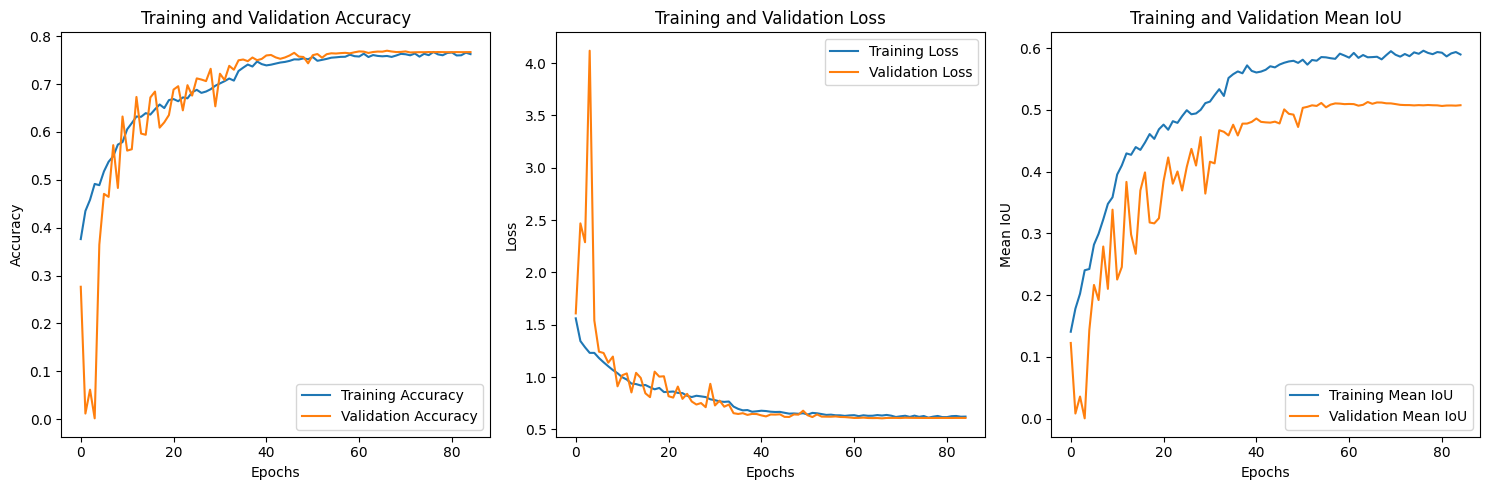

In [ ]:
# Plot training & validation accuracy, loss, and IoU
def plot_metrics(history):
    metrics = ['accuracy', 'loss', 'mean_iou']
    titles = ['Accuracy', 'Loss', 'Mean IoU']

    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[metric], label=f'Training {titles[i]}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {titles[i]}')
        plt.title(f'Training and Validation {titles[i]}')
        plt.xlabel('Epochs')
        plt.ylabel(titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_metrics(history)

## 📋 Predictions

In [ ]:
# Load the best model
model = tfk.models.load_model(model_filename, compile=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


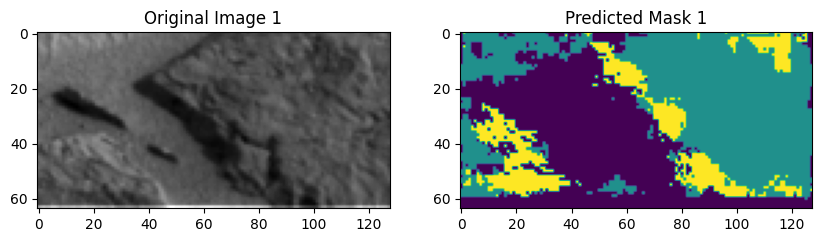

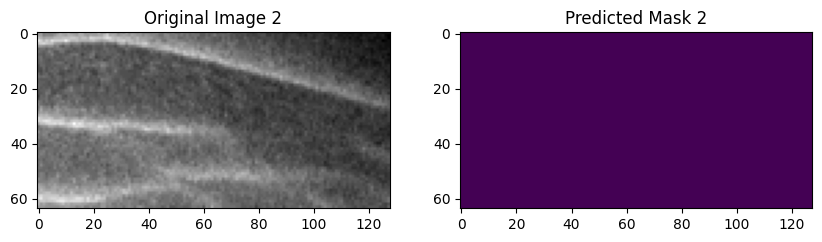

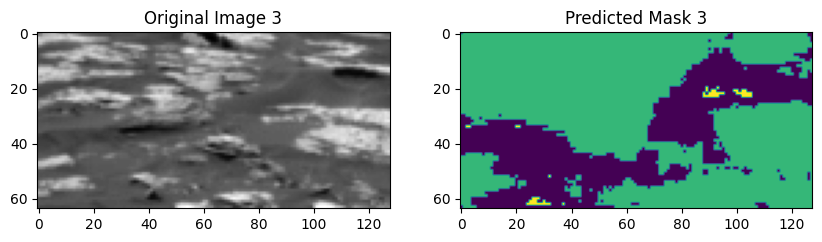

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_test is already loaded and preprocessed (normalized, with added color channel if necessary)
# If not, load and preprocess it as you did for X_train and X_val

# Predict masks for the first 3 images in X_test
predictions = model.predict(X_test[:3])

# Get the class with the highest probability for each pixel
predicted_masks = np.argmax(predictions, axis=-1)

# Display the predictions
for i in range(3):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')  # Display the original image
    plt.title(f"Original Image {i+1}")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_masks[i], cmap='viridis')  # Display the predicted mask
    plt.title(f"Predicted Mask {i+1}")

    plt.show()

## 🔬 Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


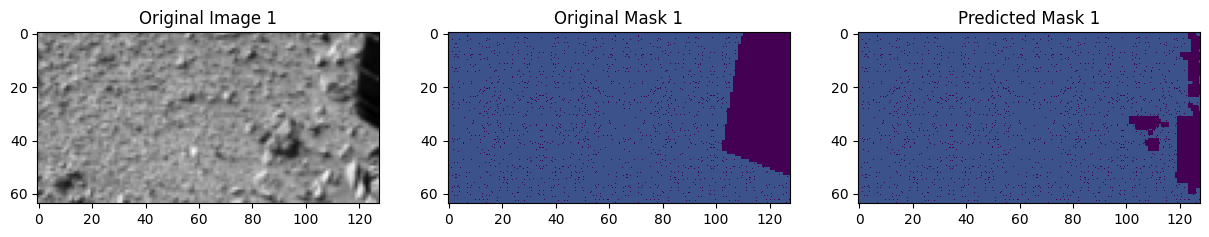

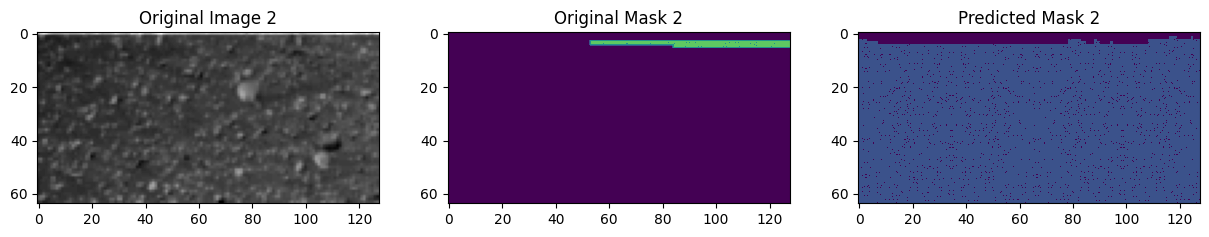

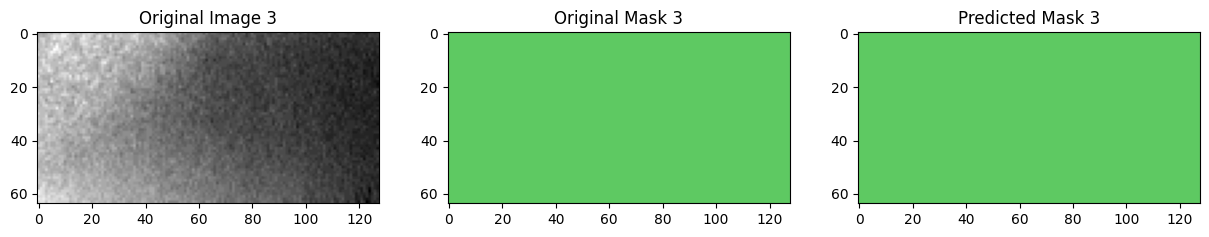

In [ ]:
import matplotlib.pyplot as plt

predictions = model.predict(X_train[:3])
predicted_masks = np.argmax(predictions, axis=-1)

# Display the predictions
for i in range(3):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')  # Display the original image
    plt.title(f"Original Image {i+1}")

    plt.subplot(1, 3, 2)
    plt.imshow(y_train[i], cmap=cmap, norm=norm)  # Display the original mask
    plt.title(f"Original Mask {i+1}")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[i], cmap=cmap, norm=norm)  # Display the predicted mask
    plt.title(f"Predicted Mask {i+1}")

    plt.show()

In [ ]:
# Mean IoU
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes)
mean_iou.update_state(y_train[:3], predicted_masks)
iou = mean_iou.result().numpy()
print(f"Mean IoU: {iou}")

# Pixel accuracy
pixel_accuracy = np.mean(y_train[:3] == predicted_masks)
print(f"Pixel accuracy: {pixel_accuracy}")

Mean IoU: 0.500690758228302
Pixel accuracy: 0.6489664713541666


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

def evaluate_per_class(y_true, y_pred, num_classes=5):
    """
    Compute precision, recall, F1-score e IoU for each class.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    metrics = {
        "Class": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": [],
        "IoU": []
    }

    for c in range(num_classes):
        class_true = (y_true_flat == c).astype(int)
        class_pred = (y_pred_flat == c).astype(int)

        precision = precision_score(class_true, class_pred, zero_division=0)
        recall = recall_score(class_true, class_pred, zero_division=0)
        f1 = f1_score(class_true, class_pred, zero_division=0)
        iou = jaccard_score(class_true, class_pred, zero_division=0)

        metrics["Class"].append(c)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1-Score"].append(f1)
        metrics["IoU"].append(iou)

    return metrics

# Prediction on the validation set
val_predictions = model.predict(X_val, verbose=0)
val_predicted_masks = np.argmax(val_predictions, axis=-1)

# Metrics
metrics = evaluate_per_class(y_val, val_predicted_masks)

# Results
import pandas as pd
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

   Class  Precision    Recall  F1-Score       IoU
0      0   0.683884  0.502301  0.579194  0.407652
1      1   0.794061  0.918542  0.851778  0.741823
2      2   0.751361  0.750273  0.750817  0.601046
3      3   0.809202  0.856772  0.832308  0.712780
4      4   0.333613  0.211573  0.258933  0.148721


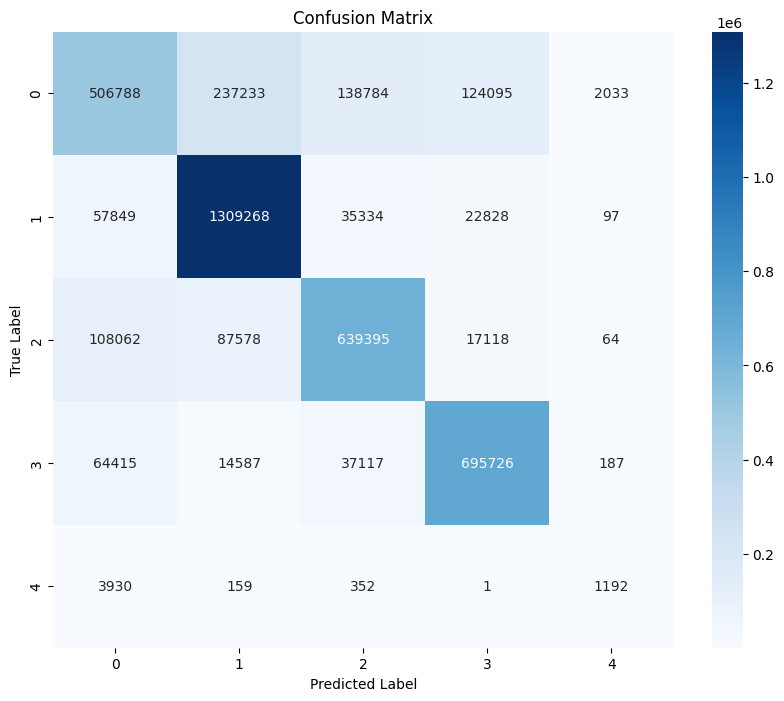

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, num_classes=5):
    """
    Plotta la matrice di confusione.
    """
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten(), labels=range(num_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Plot matrice di confusione
plot_confusion_matrix(y_val, val_predicted_masks, num_classes=5)

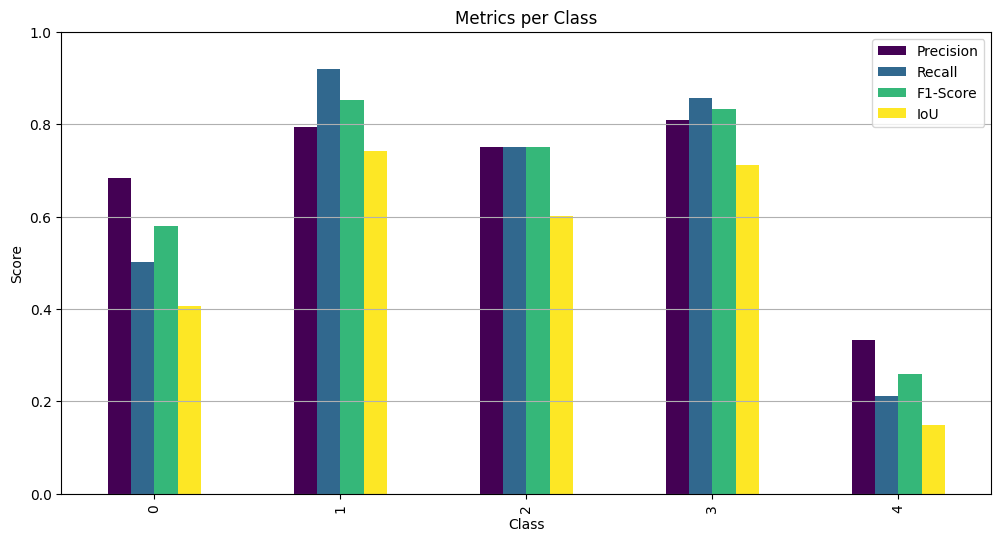

In [ ]:
def plot_metrics(metrics_df):
    """
    Plotta le metriche per classe.
    """
    metrics_df.plot(
        x="Class",
        y=["Precision", "Recall", "F1-Score", "IoU"],
        kind="bar",
        figsize=(12, 6),
        colormap="viridis",
        title="Metrics per Class"
    )
    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(axis="y")
    plt.show()

# Plot delle metriche
plot_metrics(metrics_df)

---

## 📊 Prepare Your Submission



In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)

    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
# model = tfk.models.load_model(model_filename)
# print(f"Model loaded from {model_filename}")

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)

print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]

    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(f"_{final_val_meanIoU}", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
print(f"{submission_filename}")

# from google.colab import files
# files.download(submission_filename)

submission_241207_111831.csv


#  

<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">



<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/



<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/

___

Credits: Alberto Archetti 📧 alberto.archetti@polito.it











```

   Copyright 2024 Alberto Archetti



   Licensed under the Apache License, Version 2.0 (the "License");

   you may not use this file except in compliance with the License.

   You may obtain a copy of the License at



       http://www.apache.org/licenses/LICENSE-2.0



   Unless required by applicable law or agreed to in writing, software

   distributed under the License is distributed on an "AS IS" BASIS,

   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

   See the License for the specific language governing permissions and

   limitations under the License.

```